In [25]:
import json
from collections import Counter, defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from typing import List, Dict
import re
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [26]:
TRAIN_FILE = "train.jsonl"
DEV_FILE = "paper_dev.jsonl"
TEST_FILE = "paper_test.jsonl"
EVIDENCE_FILE = "wiki-pages/wiki-001.jsonl"  # Sample evidence file

print(f"Configuration:")
print(f"  Train file: {TRAIN_FILE}")
print(f"  Dev file: {DEV_FILE}")
print(f"  Test file: {TEST_FILE}")
print(f"  Evidence file: {EVIDENCE_FILE}")

Configuration:
  Train file: train.jsonl
  Dev file: paper_dev.jsonl
  Test file: paper_test.jsonl
  Evidence file: wiki-pages/wiki-001.jsonl


In [27]:
def load_jsonl(filepath, max_lines=None):
    """Load JSONL file"""
    data = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if max_lines and i >= max_lines:
                    break
                data.append(json.loads(line.strip()))
        print(f"✓ Loaded {len(data)} records from {filepath}")
    except FileNotFoundError:
        print(f"❌ File not found: {filepath}")
    return data

In [28]:
train_data = load_jsonl(TRAIN_FILE)
dev_data = load_jsonl(DEV_FILE)
test_data = load_jsonl(TEST_FILE)

✓ Loaded 145449 records from train.jsonl
✓ Loaded 9999 records from paper_dev.jsonl
✓ Loaded 9999 records from paper_test.jsonl


In [29]:
print("="*70)
print("BASIC DATASET STRUCTURE")
print("="*70)

print(f"\nTotal number of claims: {len(train_data)}")

if train_data:
    first_claim = train_data[0]
    print(f"\nFields in each claim object:")
    for key, value in first_claim.items():
        value_type = type(value).__name__
        print(f"  • {key}: {value_type}")
    
    print(f"\n{'─'*70}")
    print("TRAIN SAMPLE CLAIM (First Record):")
    print('─'*70)
    print(json.dumps(first_claim, indent=2))

if test_data:
    first_claim = test_data[0]
    print(f"\nFields in each claim object:")
    for key, value in first_claim.items():
        value_type = type(value).__name__
        print(f"  • {key}: {value_type}")
    
    print(f"\n{'─'*70}")
    print("TEST SAMPLE CLAIM (First Record):")
    print('─'*70)
    print(json.dumps(first_claim, indent=2))

if dev_data:
    first_claim = dev_data[0]
    print(f"\nFields in each claim object:")
    for key, value in first_claim.items():
        value_type = type(value).__name__
        print(f"  • {key}: {value_type}")
    
    print(f"\n{'─'*70}")
    print("VALID SAMPLE CLAIM (First Record):")
    print('─'*70)
    print(json.dumps(first_claim, indent=2))


BASIC DATASET STRUCTURE

Total number of claims: 145449

Fields in each claim object:
  • id: int
  • verifiable: str
  • label: str
  • claim: str
  • evidence: list

──────────────────────────────────────────────────────────────────────
TRAIN SAMPLE CLAIM (First Record):
──────────────────────────────────────────────────────────────────────
{
  "id": 75397,
  "verifiable": "VERIFIABLE",
  "label": "SUPPORTS",
  "claim": "Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.",
  "evidence": [
    [
      [
        92206,
        104971,
        "Nikolaj_Coster-Waldau",
        7
      ],
      [
        92206,
        104971,
        "Fox_Broadcasting_Company",
        0
      ]
    ]
  ]
}

Fields in each claim object:
  • id: int
  • verifiable: str
  • label: str
  • claim: str
  • evidence: list

──────────────────────────────────────────────────────────────────────
TEST SAMPLE CLAIM (First Record):
──────────────────────────────────────────────────────────────────────
{

In [30]:
def visualise(label_counts):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    labels_list = list(label_counts.keys())
    counts_list = list(label_counts.values())
    colors = ['#2ecc71', '#e74c3c', '#f39c12']
    
    ax1.bar(labels_list, counts_list, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax1.set_title('Label Distribution (Count)', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, (label, count) in enumerate(zip(labels_list, counts_list)):
        ax1.text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax2.pie(counts_list, labels=labels_list, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


In [31]:
def explore_dataset(dataset_type, data):
    labels = [claim.get('label', 'MISSING') for claim in data]
    label_counts = Counter(labels)
    
    print("="*70)
    print(dataset_type + " LABEL DISTRIBUTION")
    print("="*70)
    
    total = len(labels)
    print(f"\nTotal claims: {total}\n")
    
    for label, count in label_counts.most_common():
        percentage = (count / total) * 100
        bar = '█' * int(percentage / 2)
        print(f"{label:20s}: {count:6d} ({percentage:5.2f}%) {bar}")
    visualise(label_counts)


TRAIN LABEL DISTRIBUTION

Total claims: 145449

SUPPORTS            :  80035 (55.03%) ███████████████████████████
NOT ENOUGH INFO     :  35639 (24.50%) ████████████
REFUTES             :  29775 (20.47%) ██████████


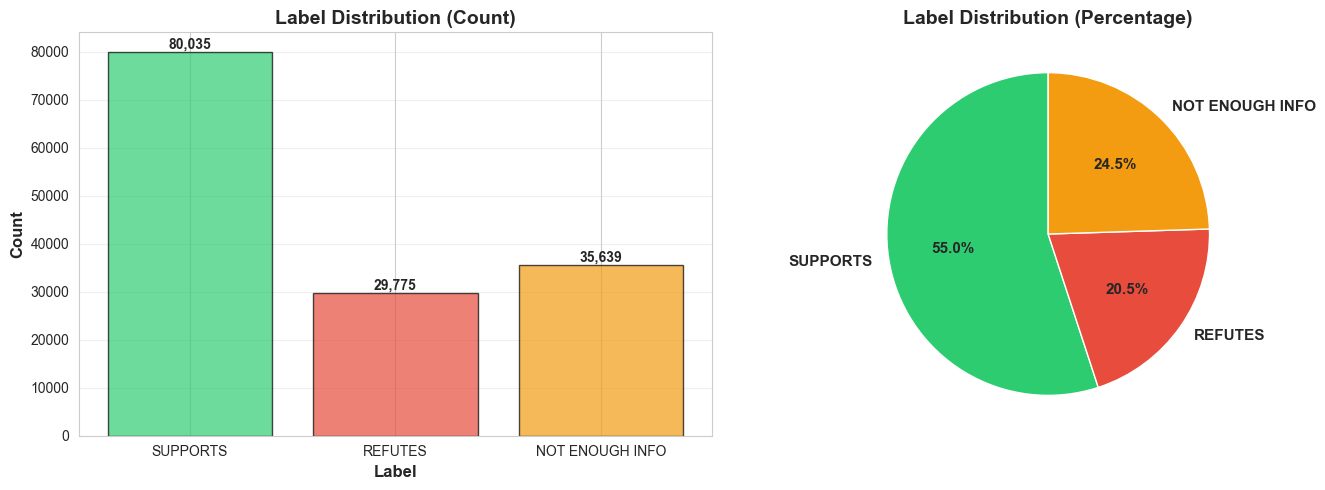

In [32]:
explore_dataset("TRAIN",train_data)

TEST LABEL DISTRIBUTION

Total claims: 9999

NOT ENOUGH INFO     :   3333 (33.33%) ████████████████
SUPPORTS            :   3333 (33.33%) ████████████████
REFUTES             :   3333 (33.33%) ████████████████


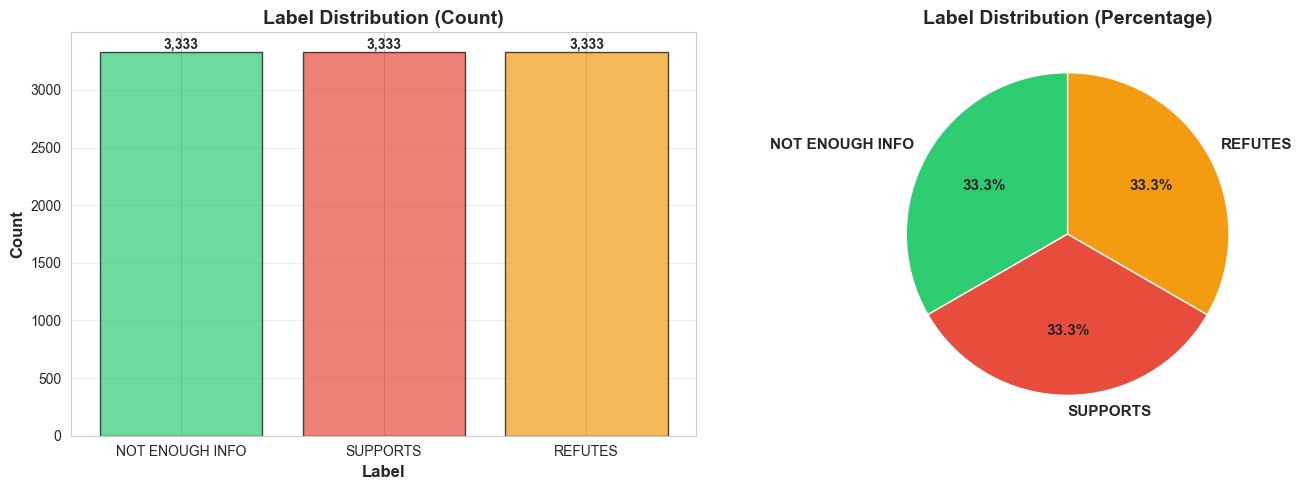

In [33]:
explore_dataset("TEST",test_data)

VALIDATION LABEL DISTRIBUTION

Total claims: 9999

NOT ENOUGH INFO     :   3333 (33.33%) ████████████████
SUPPORTS            :   3333 (33.33%) ████████████████
REFUTES             :   3333 (33.33%) ████████████████


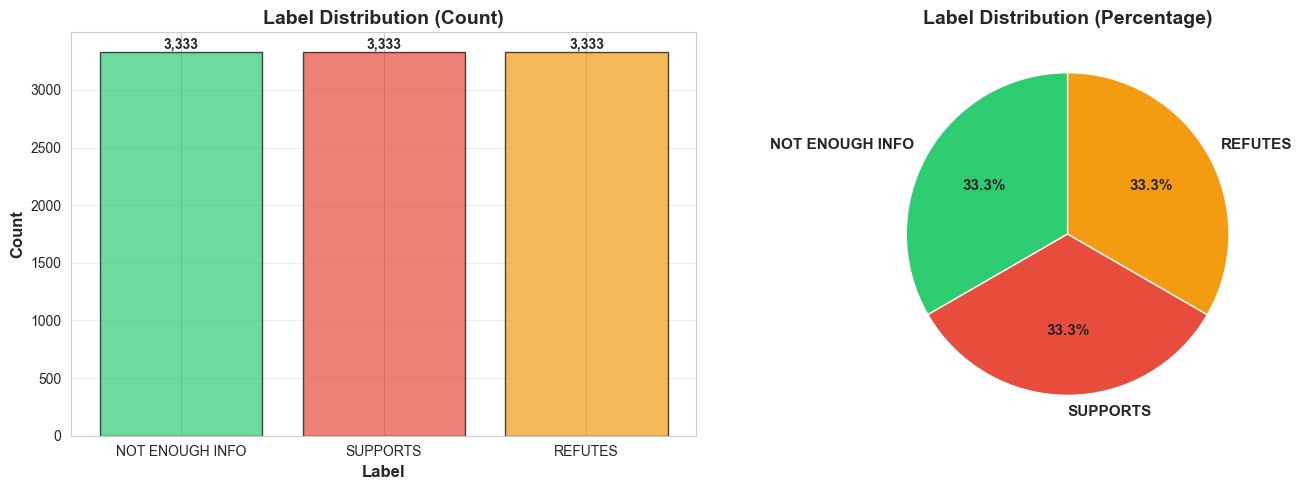

In [34]:
explore_dataset("VALIDATION",dev_data)

In [35]:
def discover_wiki_files(wiki_dir: str) -> List[Path]:
    """Find all wiki-*.jsonl files in the directory."""
    wiki_path = Path(wiki_dir)
    if not wiki_path.exists():
        print(f"❌ Directory '{wiki_dir}' not found!")
        return []

    wiki_files = sorted(wiki_path.glob("*.jsonl"))
    print(f"📁 Found {len(wiki_files)} wiki files")
    return wiki_files

def sample_files(wiki_files: List[Path], num_samples: int) -> List[Path]:
    """Randomly sample files to explore."""
    if len(wiki_files) <= num_samples:
        return wiki_files
    return random.sample(wiki_files, num_samples)


In [36]:
def load_articles_from_file(file_path: Path, max_articles: int = None) -> List[Dict]:
    """Load articles from a JSONL file, skipping empty entries."""
    articles = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            try:
                article = json.loads(line.strip())
                articles.append(article)
                if max_articles and len(articles) >= max_articles:
                    break
            except json.JSONDecodeError:
                print(f"⚠️  Skipping invalid JSON at line {line_num} in {file_path.name}")
    return articles

def parse_lines_field(lines_str: str) -> List[Dict]:
    """Parse the lines field into structured data."""
    if not lines_str:
        return []

    parsed_lines = []
    for line in lines_str.strip().split('\n'):
        if not line.strip():
            continue
        parts = line.split('\t')
        if len(parts) >= 2:
            parsed_lines.append({
                'line_num': parts[0],
                'sentence': parts[1],
                'entities': parts[2:] if len(parts) > 2 else []
            })
    return parsed_lines

In [37]:
def explore_basic_stats(all_articles: List[Dict]):
    """Basic statistics about the dataset."""
    print("\n" + "="*40)
    print("📊 BASIC DATASET STATISTICS")
    print("="*40)

    total_articles = len(all_articles)
    print(f"Total articles loaded: {total_articles}")

    # Calculate sentence counts
    sentence_counts = []
    char_counts = []
    has_entities = 0

    for article in all_articles:
        parsed_lines = parse_lines_field(article.get('lines', ''))
        sentence_counts.append(len(parsed_lines))
        char_counts.append(len(article.get('text', '')))

        # Check if any line has entity information
        if any(line['entities'] for line in parsed_lines):
            has_entities += 1

    print(f"\nSentences per article:")
    print(f"  Min: {min(sentence_counts)}")
    print(f"  Max: {max(sentence_counts)}")
    print(f"  Mean: {np.mean(sentence_counts):.2f}")
    print(f"  Median: {np.median(sentence_counts):.2f}")
    print(f"  Std Dev: {np.std(sentence_counts):.2f}")

    print(f"\nCharacters per article:")
    print(f"  Min: {min(char_counts)}")
    print(f"  Max: {max(char_counts)}")
    print(f"  Mean: {np.mean(char_counts):.2f}")
    print(f"  Median: {np.median(char_counts):.2f}")

    print(f"\nArticles with entity links: {has_entities} ({has_entities/total_articles*100:.1f}%)")

    return sentence_counts, char_counts

def explore_text_content(all_articles: List[Dict], num_display: int = 3):
    """Explore actual text content and formatting."""
    print("\n" + "="*70)
    print("📝 SAMPLE ARTICLE CONTENT")
    print("="*70)

    sample_articles = random.sample(all_articles, min(num_display, len(all_articles)))

    for i, article in enumerate(sample_articles, 1):
        print(f"\n--- Sample Article {i} ---")
        print(f"ID: {article['id']}")

        parsed_lines = parse_lines_field(article.get('lines', ''))
        print(f"Number of sentences: {len(parsed_lines)}")

        # Show first 3 sentences
        print(f"\nFirst 3 sentences:")
        for j, line_data in enumerate(parsed_lines[:3], 1):
            sentence = line_data['sentence']
            print(f"  {j}. {sentence[:150]}{'...' if len(sentence) > 150 else ''}")

        # Check for formatting artifacts
        text = article['text']
        has_lrb = '-LRB-' in text or '-RRB-' in text
        if has_lrb:
            print(f"  ⚠️  Contains -LRB-/-RRB- bracket formatting")

def explore_formatting_artifacts(all_articles: List[Dict]):
    """Check for common formatting issues."""
    print("\n" + "="*70)
    print("🔍 FORMATTING ARTIFACTS")
    print("="*70)

    artifacts = {
        '-LRB-': 0,
        '-RRB-': 0,
        '-LSB-': 0,
        '-RSB-': 0,
        '&nbsp;': 0,
        '&amp;': 0,
    }

    for article in all_articles:
        text = article['text']
        for artifact in artifacts:
            if artifact in text:
                artifacts[artifact] += 1

    print("Artifacts found (articles containing):")
    for artifact, count in artifacts.items():
        if count > 0:
            pct = count / len(all_articles) * 100
            print(f"  {artifact:10s}: {count:5d} articles ({pct:5.1f}%)")

def explore_sentence_lengths(all_articles: List[Dict]):
    """Analyze sentence-level statistics."""
    print("\n" + "="*70)
    print("📏 SENTENCE-LEVEL ANALYSIS")
    print("="*70)

    all_sentences = []
    sentence_char_lengths = []

    for article in all_articles:
        parsed_lines = parse_lines_field(article.get('lines', ''))
        for line_data in parsed_lines:
            sentence = line_data['sentence']
            all_sentences.append(sentence)
            sentence_char_lengths.append(len(sentence))

    print(f"Total sentences analyzed: {len(all_sentences)}")
    print(f"\nCharacters per sentence:")
    print(f"  Min: {min(sentence_char_lengths)}")
    print(f"  Max: {max(sentence_char_lengths)}")
    print(f"  Mean: {np.mean(sentence_char_lengths):.2f}")
    print(f"  Median: {np.median(sentence_char_lengths):.2f}")
    print(f"  25th percentile: {np.percentile(sentence_char_lengths, 25):.2f}")
    print(f"  75th percentile: {np.percentile(sentence_char_lengths, 75):.2f}")

    return sentence_char_lengths

def identify_edge_cases(all_articles: List[Dict]):
    """Identify potential problematic articles."""
    print("\n" + "="*70)
    print("⚠️  EDGE CASES")
    print("="*70)

    very_short = []
    very_long = []
    empty_lines = []

    for article in all_articles:
        parsed_lines = parse_lines_field(article.get('lines', ''))
        num_sentences = len(parsed_lines)

        if num_sentences < 3:
            very_short.append((article['id'], num_sentences))
        elif num_sentences > 200:
            very_long.append((article['id'], num_sentences))

        if not article.get('lines', '').strip():
            empty_lines.append(article['id'])

    print(f"Very short articles (< 3 sentences): {len(very_short)}")
    if very_short:
        print("  Examples:")
        for article_id, count in very_short[:3]:
            print(f"    - {article_id}: {count} sentences")

    print(f"\nVery long articles (> 200 sentences): {len(very_long)}")
    if very_long:
        print("  Examples:")
        for article_id, count in very_long[:3]:
            print(f"    - {article_id}: {count} sentences")

    print(f"\nArticles with empty lines field: {len(empty_lines)}")


In [38]:
def create_statistics_table(sentence_counts, char_counts, sentence_char_lengths):
    """Create an interactive statistics table."""

    stats_data = {
        'Metric': [
            'Count',
            'Min',
            'Max',
            'Mean',
            'Median',
            'Std Dev',
            '25th Percentile',
            '75th Percentile',
            '90th Percentile',
            '95th Percentile'
        ],
        'Sentences per Article': [
            len(sentence_counts),
            np.min(sentence_counts),
            np.max(sentence_counts),
            np.mean(sentence_counts),
            np.median(sentence_counts),
            np.std(sentence_counts),
            np.percentile(sentence_counts, 25),
            np.percentile(sentence_counts, 75),
            np.percentile(sentence_counts, 90),
            np.percentile(sentence_counts, 95)
        ],
        'Characters per Article': [
            len(char_counts),
            np.min(char_counts),
            np.max(char_counts),
            np.mean(char_counts),
            np.median(char_counts),
            np.std(char_counts),
            np.percentile(char_counts, 25),
            np.percentile(char_counts, 75),
            np.percentile(char_counts, 90),
            np.percentile(char_counts, 95)
        ],
        'Characters per Sentence': [
            len(sentence_char_lengths),
            np.min(sentence_char_lengths),
            np.max(sentence_char_lengths),
            np.mean(sentence_char_lengths),
            np.median(sentence_char_lengths),
            np.std(sentence_char_lengths),
            np.percentile(sentence_char_lengths, 25),
            np.percentile(sentence_char_lengths, 75),
            np.percentile(sentence_char_lengths, 90),
            np.percentile(sentence_char_lengths, 95)
        ]
    }

    # Format the numbers
    formatted_data = {
        'Metric': stats_data['Metric'],
        'Sentences per Article': [f"{x:.2f}" for x in stats_data['Sentences per Article']],
        'Characters per Article': [f"{x:.2f}" for x in stats_data['Characters per Article']],
        'Characters per Sentence': [f"{x:.2f}" for x in stats_data['Characters per Sentence']]
    }

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(formatted_data.keys()),
            fill_color='paleturquoise',
            align='left',
            font=dict(size=12, color='black')
        ),
        cells=dict(
            values=[formatted_data[k] for k in formatted_data.keys()],
            fill_color='lavender',
            align='left',
            font=dict(size=11)
        )
    )])

    fig.update_layout(
        title="Detailed Statistics Summary",
        height=400
    )

    fig.show()


In [39]:
def create_visualizations(sentence_counts, char_counts, sentence_char_lengths):
    """Create interactive visualizations with zoom and hover capabilities."""

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Distribution of Sentences per Article',
            'Distribution of Characters per Article',
            'Distribution of Sentence Lengths',
            'Box Plot Comparison'
        ),
        specs=[[{'type': 'histogram'}, {'type': 'histogram'}],
               [{'type': 'histogram'}, {'type': 'box'}]]
    )

    # Plot 1: Sentences per article distribution
    fig.add_trace(
        go.Histogram(
            x=sentence_counts,
            nbinsx=50,
            name='Sentences per Article',
            marker_color='rgb(55, 83, 109)',
            opacity=0.7,
            hovertemplate='Sentences: %{x}<br>Count: %{y}<extra></extra>'
        ),
        row=1, col=1
    )

    # Add mean line for plot 1
    mean_sentences = np.mean(sentence_counts)
    fig.add_vline(
        x=mean_sentences,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Mean: {mean_sentences:.1f}",
        annotation_position="top right",
        row=1, col=1
    )

    # Plot 2: Characters per article distribution
    fig.add_trace(
        go.Histogram(
            x=char_counts,
            nbinsx=50,
            name='Characters per Article',
            marker_color='rgb(26, 118, 255)',
            opacity=0.7,
            hovertemplate='Characters: %{x}<br>Count: %{y}<extra></extra>'
        ),
        row=1, col=2
    )

    # Add mean line for plot 2
    mean_chars = np.mean(char_counts)
    fig.add_vline(
        x=mean_chars,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Mean: {mean_chars:.0f}",
        annotation_position="top right",
        row=1, col=2
    )

    # Plot 3: Sentence length distribution
    fig.add_trace(
        go.Histogram(
            x=sentence_char_lengths,
            nbinsx=50,
            name='Characters per Sentence',
            marker_color='rgb(255, 127, 14)',
            opacity=0.7,
            hovertemplate='Characters: %{x}<br>Count: %{y}<extra></extra>'
        ),
        row=2, col=1
    )

    # Add mean line for plot 3
    mean_sent_chars = np.mean(sentence_char_lengths)
    fig.add_vline(
        x=mean_sent_chars,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Mean: {mean_sent_chars:.1f}",
        annotation_position="top right",
        row=2, col=1
    )

    # Plot 4: Box plot comparison
    fig.add_trace(
        go.Box(
            y=sentence_counts,
            name='Sentences<br>per Article',
            marker_color='rgb(55, 83, 109)',
            boxmean='sd',
            hovertemplate='Value: %{y}<extra></extra>'
        ),
        row=2, col=2
    )

    fig.add_trace(
        go.Box(
            y=[x/100 for x in char_counts],
            name='Chars per Article<br>(÷100)',
            marker_color='rgb(26, 118, 255)',
            boxmean='sd',
            hovertemplate='Value: %{y:.1f} (×100)<extra></extra>'
        ),
        row=2, col=2
    )

    fig.add_trace(
        go.Box(
            y=[x/10 for x in sentence_char_lengths],
            name='Chars per Sentence<br>(÷10)',
            marker_color='rgb(255, 127, 14)',
            boxmean='sd',
            hovertemplate='Value: %{y:.1f} (×10)<extra></extra>'
        ),
        row=2, col=2
    )

    # Update layout for better interactivity
    fig.update_xaxes(title_text="Number of Sentences", row=1, col=1)
    fig.update_yaxes(title_text="Number of Articles", row=1, col=1)

    fig.update_xaxes(title_text="Number of Characters", row=1, col=2)
    fig.update_yaxes(title_text="Number of Articles", row=1, col=2)

    fig.update_xaxes(title_text="Characters per Sentence", row=2, col=1)
    fig.update_yaxes(title_text="Number of Sentences", row=2, col=1)

    fig.update_yaxes(title_text="Count", row=2, col=2)

    # Overall layout
    fig.update_layout(
        height=900,
        showlegend=False,
        title_text="Wikipedia Dataset Statistics - Interactive Visualization",
        title_x=0.5,
        hovermode='closest'
    )

    # Show the plot
    fig.show()

    # Also create a detailed statistics table
    create_statistics_table(sentence_counts, char_counts, sentence_char_lengths)


In [40]:
# def create_visualizations(sentence_counts, char_counts, sentence_char_lengths):
#     """Create helpful visualizations."""
#     fig, axes = plt.subplots(2, 2, figsize=(14, 10))
#
#     # Plot 1: Sentences per article distribution
#     ax1 = axes[0, 0]
#     ax1.hist(sentence_counts, bins=50, edgecolor='black', alpha=0.7)
#     ax1.set_xlabel('Number of Sentences')
#     ax1.set_ylabel('Number of Articles')
#     ax1.set_title('Distribution of Sentences per Article')
#     ax1.axvline(np.mean(sentence_counts), color='red', linestyle='--',
#                 label=f'Mean: {np.mean(sentence_counts):.1f}')
#     ax1.legend()
#
#     # Plot 2: Characters per article distribution
#     ax2 = axes[0, 1]
#     ax2.hist(char_counts, bins=50, edgecolor='black', alpha=0.7, color='green')
#     ax2.set_xlabel('Number of Characters')
#     ax2.set_ylabel('Number of Articles')
#     ax2.set_title('Distribution of Characters per Article')
#     ax2.axvline(np.mean(char_counts), color='red', linestyle='--',
#                 label=f'Mean: {np.mean(char_counts):.1f}')
#     ax2.legend()
#
#     # Plot 3: Sentence length distribution
#     ax3 = axes[1, 0]
#     ax3.hist(sentence_char_lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
#     ax3.set_xlabel('Characters per Sentence')
#     ax3.set_ylabel('Number of Sentences')
#     ax3.set_title('Distribution of Sentence Lengths')
#     ax3.axvline(np.mean(sentence_char_lengths), color='red', linestyle='--',
#                 label=f'Mean: {np.mean(sentence_char_lengths):.1f}')
#     ax3.legend()
#
#     # Plot 4: Box plot comparison
#     ax4 = axes[1, 1]
#     data_to_plot = [sentence_counts,
#                     [x/100 for x in char_counts],  # Scale down for visibility
#                     [x/10 for x in sentence_char_lengths]]  # Scale down
#     ax4.boxplot(data_to_plot, tick_labels=['Sentences\nper Article',
#                                        'Chars per Article\n(÷100)',
#                                        'Chars per Sentence\n(÷10)'])
#     ax4.set_ylabel('Count')
#     ax4.set_title('Box Plot Comparison')
#     ax4.grid(True, alpha=0.3)
#
#     plt.tight_layout()
#     plt.show()

In [41]:
# Configuration for exploration
WIKI_DIR = "wiki-pages/wiki-pages"
NUM_FILES_TO_SAMPLE = 100
ARTICLES_PER_FILE = 100

In [42]:
def run_exploration(directory):
    """Run the complete exploration pipeline."""
    print("="*40)
    print("🔬 WIKIPEDIA EVIDENCE DATASET EXPLORATION")
    print("="*40)

    # Step 1: Discover files
    wiki_files = discover_wiki_files(directory)
    if not wiki_files:
        return

    # Step 2: Sample files
    sampled_files = sample_files(wiki_files, NUM_FILES_TO_SAMPLE)
    print(f"\n🎲 Randomly selected {len(sampled_files)} files to explore:")
    for f in sampled_files:
        print(f"  - {f.name}")

    # Step 3: Load articles
    print(f"\n📖 Loading up to {ARTICLES_PER_FILE} articles from each file...")
    all_articles = []
    for file_path in sampled_files:
        articles = load_articles_from_file(file_path, ARTICLES_PER_FILE)
        all_articles.extend(articles)
        print(f"  Loaded {len(articles)} articles from {file_path.name}")

    if not all_articles:
        print("❌ No articles loaded!")
        return

    # Step 4: Run explorations
    sentence_counts, char_counts = explore_basic_stats(all_articles)
    explore_text_content(all_articles, num_display=3)
    explore_formatting_artifacts(all_articles)
    sentence_char_lengths = explore_sentence_lengths(all_articles)
    identify_edge_cases(all_articles)

    # Step 5: Create visualizations
    print("\n📊 Generating visualizations...")
    create_visualizations(sentence_counts, char_counts, sentence_char_lengths)

    return len(all_articles)

random.seed(42)
np.random.seed(42)
run_exploration(WIKI_DIR)

🔬 WIKIPEDIA EVIDENCE DATASET EXPLORATION
📁 Found 109 wiki files

🎲 Randomly selected 100 files to explore:
  - wiki-082.jsonl
  - wiki-015.jsonl
  - wiki-004.jsonl
  - wiki-095.jsonl
  - wiki-036.jsonl
  - wiki-032.jsonl
  - wiki-029.jsonl
  - wiki-018.jsonl
  - wiki-106.jsonl
  - wiki-014.jsonl
  - wiki-087.jsonl
  - wiki-101.jsonl
  - wiki-070.jsonl
  - wiki-012.jsonl
  - wiki-076.jsonl
  - wiki-055.jsonl
  - wiki-005.jsonl
  - wiki-107.jsonl
  - wiki-096.jsonl
  - wiki-028.jsonl
  - wiki-030.jsonl
  - wiki-065.jsonl
  - wiki-078.jsonl
  - wiki-092.jsonl
  - wiki-072.jsonl
  - wiki-026.jsonl
  - wiki-097.jsonl
  - wiki-054.jsonl
  - wiki-103.jsonl
  - wiki-058.jsonl
  - wiki-098.jsonl
  - wiki-105.jsonl
  - wiki-001.jsonl
  - wiki-021.jsonl
  - wiki-094.jsonl
  - wiki-044.jsonl
  - wiki-099.jsonl
  - wiki-020.jsonl
  - wiki-090.jsonl
  - wiki-074.jsonl
  - wiki-100.jsonl
  - wiki-091.jsonl
  - wiki-049.jsonl
  - wiki-013.jsonl
  - wiki-046.jsonl
  - wiki-045.jsonl
  - wiki-039.jsonl


10000

In [43]:
def find_special_patterns(wiki_dir=WIKI_DIR, num_files=10):
    """Discover all special character patterns in Wikipedia text."""

    # Patterns to look for
    dash_pattern = re.compile(r'-[A-Z]+-')  # -LRB-, -RRB-, etc.
    html_entity = re.compile(r'&[a-zA-Z]+;')  # &nbsp;, &amp;, etc.

    dash_patterns = Counter()
    html_entities = Counter()

    wiki_files = sorted(Path(wiki_dir).glob("wiki-*.jsonl"))[:num_files]

    print(f"Scanning {len(wiki_files)} files for special characters...")

    for file_path in tqdm(wiki_files):
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    article = json.loads(line.strip())
                    text = article.get('text', '')

                    if not text:
                        continue

                    # Find dash patterns
                    for match in dash_pattern.findall(text):
                        dash_patterns[match] += 1

                    # Find HTML entities
                    for match in html_entity.findall(text):
                        html_entities[match] += 1

                except:
                    continue

    # Display results
    print("\n" + "="*70)
    print("SPECIAL CHARACTER PATTERNS FOUND")
    print("="*70)

    print("\nDash patterns (e.g., -LRB-):")
    for pattern, count in dash_patterns.most_common(20):
        print(f"  {pattern:15s}: {count:,} occurrences")

    print("\nHTML entities (e.g., &nbsp;):")
    for entity, count in html_entities.most_common(20):
        print(f"  {entity:15s}: {count:,} occurrences")

    return dash_patterns, html_entities

# Run the discovery
dash_patterns, html_entities = find_special_patterns(num_files=200)

Scanning 109 files for special characters...


100%|██████████| 109/109 [00:40<00:00,  2.70it/s]


SPECIAL CHARACTER PATTERNS FOUND

Dash patterns (e.g., -LRB-):
  -RRB-          : 6,005,133 occurrences
  -LRB-          : 6,004,114 occurrences
  -LSB-          : 203,727 occurrences
  -RSB-          : 199,128 occurrences
  -RCB-          : 10,021 occurrences
  -D-            : 4,642 occurrences
  -LCB-          : 3,109 occurrences
  -L-            : 2,396 occurrences
  -O-            : 1,738 occurrences
  -N-            : 1,679 occurrences
  -A-            : 1,652 occurrences
  -S-            : 414 occurrences
  -E-            : 352 occurrences
  -I-            : 297 occurrences
  -B-            : 234 occurrences
  -TV-           : 218 occurrences
  -C-            : 211 occurrences
  -STD-          : 202 occurrences
  -P-            : 189 occurrences
  -AO-           : 144 occurrences

HTML entities (e.g., &nbsp;):


In [44]:
WIKI_DIR = "reduced_fever_data/wiki"
run_exploration(WIKI_DIR)


🔬 WIKIPEDIA EVIDENCE DATASET EXPLORATION
📁 Found 1 wiki files

🎲 Randomly selected 1 files to explore:
  - filtered_evidence.jsonl

📖 Loading up to 100 articles from each file...
  Loaded 100 articles from filtered_evidence.jsonl

📊 BASIC DATASET STATISTICS
Total articles loaded: 100

Sentences per article:
  Min: 0
  Max: 56
  Mean: 7.88
  Median: 5.00
  Std Dev: 9.15

Characters per article:
  Min: 0
  Max: 4680
  Mean: 633.65
  Median: 397.00

Articles with entity links: 97 (97.0%)

📝 SAMPLE ARTICLE CONTENT

--- Sample Article 1 ---
ID: Sans-Souci_Palace
Number of sentences: 56

First 3 sentences:
  1. The Sans-Souci Palace is a palace in Haiti in the town of Milot , Nord Department , located approximately 5 km northeast of the Citadelle Laferrière ,...
  2. 
  3. 
  ⚠️  Contains -LRB-/-RRB- bracket formatting

--- Sample Article 2 ---
ID: Cancellaria_lyrata
Number of sentences: 1

First 3 sentences:
  1. Cancellaria lyrata , the lyrate nutmeg , is a species of sea snail , a marine 

100

In [ ]:
def analyze_fever_article_lengths(fever_dataset):
    """
    Check if truncation is a problem in your dataset.
    """
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    token_counts = []
    truncated_count = 0

    for article in fever_dataset:
        tokens = tokenizer.encode(article['text'], add_special_tokens=True)
        token_counts.append(len(tokens))

        if len(tokens) > 512:
            truncated_count += 1

    print(f"Total articles: {len(fever_dataset)}")
    print(f"Articles exceeding 512 tokens: {truncated_count} ({truncated_count/len(fever_dataset)*100:.1f}%)")
    print(f"Average token count: {np.mean(token_counts):.1f}")
    print(f"Max token count: {max(token_counts)}")
files = discover_wiki_files(WIKI_DIR)
analyze_fever_article_lengths(files)